In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=6)
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(seasonal_time):
  return np.where(seasonal_time<0.4,
                  np.cos(seasonal_time*2*np.pi),
                  1/np.exp(3*seasonal_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  seasonal_time = ((time+phase)%period)/period
  return amplitude*seasonal_pattern(seasonal_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level


In [5]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[-1]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

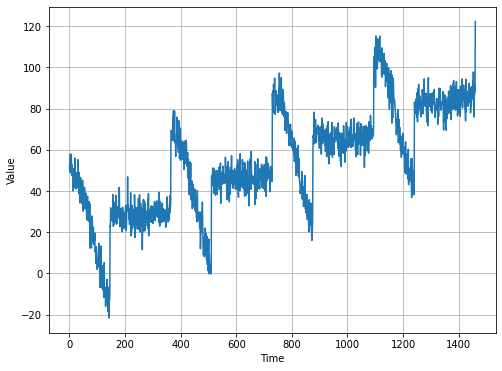

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(8,6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                 keras.layers.SimpleRNN(100, return_sequences = True),
                                 keras.layers.SimpleRNN(100),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs = 100, callbacks=[lr_schedule])

Epoch 1/500
8/8 [==============================] - 2s 46ms/step - loss: 50.2169 - mae: 50.7167 - lr: 1.0000e-07
Epoch 2/500
8/8 [==============================] - 0s 40ms/step - loss: 23.0009 - mae: 23.4932 - lr: 1.1220e-07
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 19.2073 - mae: 19.7003 - lr: 1.2589e-07
Epoch 4/500
8/8 [==============================] - 0s 39ms/step - loss: 16.9702 - mae: 17.4605 - lr: 1.4125e-07
Epoch 5/500
8/8 [==============================] - 0s 45ms/step - loss: 15.4093 - mae: 15.8988 - lr: 1.5849e-07
Epoch 6/500
8/8 [==============================] - 0s 43ms/step - loss: 14.7507 - mae: 15.2367 - lr: 1.7783e-07
Epoch 7/500
8/8 [==============================] - 0s 43ms/step - loss: 14.3058 - mae: 14.7931 - lr: 1.9953e-07
Epoch 8/500
8/8 [==============================] - 0s 42ms/step - loss: 14.0615 - mae: 14.5512 - lr: 2.2387e-07
Epoch 9/500
8/8 [==============================] - 0s 42ms/step - loss: 13.7812 - mae: 14.2687 - lr: 2.5

(1e-07, 0.0001, 0.0, 30.0)

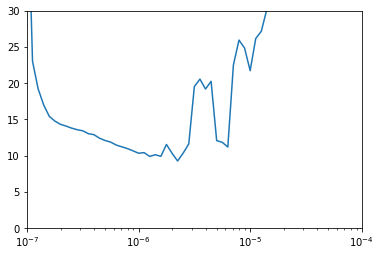

In [11]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), #adding another dimension in each record
                                 keras.layers.SimpleRNN(100, return_sequences = True),
                                 keras.layers.SimpleRNN(100),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200.0) #to normalize
])


optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
model.fit(train_set, epochs = 500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 218ms/step - loss: 76.9368 - mae: 77.4364 - val_loss: 76.1147 - val_mae: 76.6147
Epoch 2/500
8/8 [==============================] - 1s 112ms/step - loss: 32.0930 - mae: 32.5895 - val_loss: 18.1689 - val_mae: 18.6645
Epoch 3/500
8/8 [==============================] - 1s 95ms/step - loss: 33.4488 - mae: 33.9466 - val_loss: 21.7679 - val_mae: 22.2606
Epoch 4/500
8/8 [==============================] - 1s 76ms/step - loss: 25.1501 - mae: 25.6478 - val_loss: 43.2917 - val_mae: 43.7916
Epoch 5/500
8/8 [==============================] - 2s 191ms/step - loss: 24.7289 - mae: 25.2227 - val_loss: 31.0703 - val_mae: 31.5693
Epoch 6/500
8/8 [==============================] - 1s 108ms/step - loss: 22.1780 - mae: 22.6718 - val_loss: 22.2411 - val_mae: 22.7382
Epoch 7/500
8/8 [==============================] - 1s 109ms/step - loss: 20.7951 - mae: 21.2868 - val_loss: 26.0603 - val_mae: 26.5589
Epoch 8/500
8/8 [==============================] - 1s 120

In [18]:
model = tf.keras.models.load_model('model_checkpoint.h5')

In [20]:
#Defining the forecast model
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [21]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:,0]

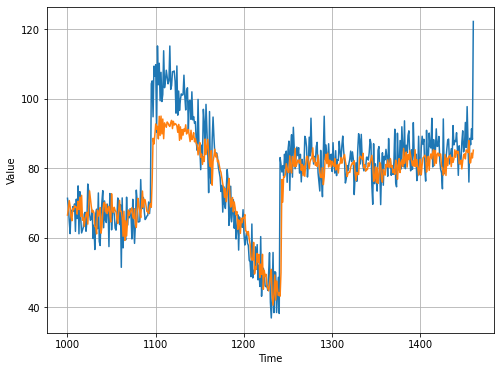

In [22]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [24]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.7516575

**Sequence to Sequence forecasting**

In [33]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  return ds.batch(batch_size).prefetch(1)

In [34]:
#Lets visualize a sample
for X_batch, y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
  print('X: ', X_batch.numpy())
  print('y: ', y_batch.numpy())

X:  [[[0]
  [1]
  [2]]]
y:  [[[1]
  [2]
  [3]]]
X:  [[[5]
  [6]
  [7]]]
y:  [[[6]
  [7]
  [8]]]
X:  [[[2]
  [3]
  [4]]]
y:  [[[3]
  [4]
  [5]]]
X:  [[[3]
  [4]
  [5]]]
y:  [[[4]
  [5]
  [6]]]
X:  [[[6]
  [7]
  [8]]]
y:  [[[7]
  [8]
  [9]]]
X:  [[[1]
  [2]
  [3]]]
y:  [[[2]
  [3]
  [4]]]
X:  [[[4]
  [5]
  [6]]]
y:  [[[5]
  [6]
  [7]]]


In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.models.Sequential([
                                    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
                                    keras.layers.SimpleRNN(100, return_sequences=True),
                                    keras.layers.Dense(1),
                                    keras.layers.Lambda(lambda x:x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch/30))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 3s 45ms/step - loss: 52.3615 - mae: 52.8611 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 25.4713 - mae: 25.9671 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 41ms/step - loss: 23.5029 - mae: 23.9971 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 21.1367 - mae: 21.6294 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 1s 44ms/step - loss: 19.4762 - mae: 19.9674 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 18.6742 - mae: 19.1647 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 1s 45ms/step - loss: 18.1698 - mae: 18.6587 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 45ms/step - loss: 17.7679 - mae: 18.2568 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 45ms/step - loss: 17.4389 - mae: 17.9280 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

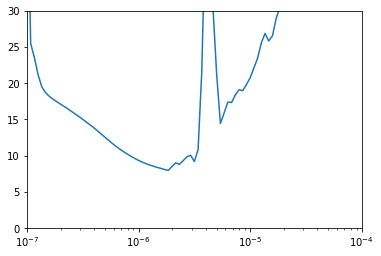

In [37]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.models.Sequential([
                                    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
                                    keras.layers.SimpleRNN(100, return_sequences=True),
                                    keras.layers.Dense(1),
                                    keras.layers.Lambda(lambda x:x*200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)
model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint('model_checkpoint2.h5', save_best_only=True)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=500, validation_data = valid_set, callbacks=[early_stopping])


Epoch 1/500
8/8 [==============================] - 4s 134ms/step - loss: 54.1428 - mae: 54.6412 - val_loss: 17.9209 - val_mae: 18.4157
Epoch 2/500
8/8 [==============================] - 1s 73ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5481 - val_mae: 21.0440
Epoch 3/500
8/8 [==============================] - 1s 71ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8711 - val_mae: 38.3705
Epoch 4/500
8/8 [==============================] - 1s 68ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2684 - val_mae: 25.7674
Epoch 5/500
8/8 [==============================] - 1s 64ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8504
Epoch 6/500
8/8 [==============================] - 1s 69ms/step - loss: 15.0382 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 1s 70ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1618 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 1s 64ms/step -

In [41]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast2 = rnn_forecast2[split_time-window_size:-1,-1,0]

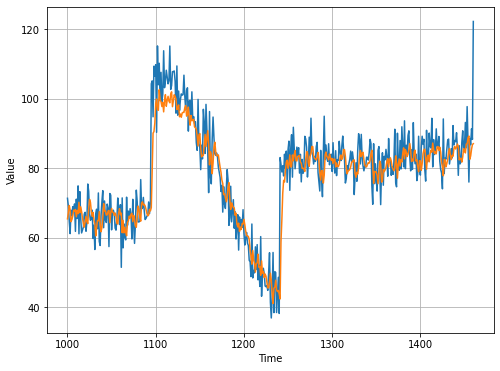

In [42]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast2)
plt.show()

In [44]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast2).numpy()

5.0335536